In [1]:
import numpy as np
import zarr
import pandas as pd
import dask.array as da
import allel
import matplotlib.pyplot as plt
%matplotlib inline

## Cluster setup

In [2]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [4]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.8.30.9:41679 Dashboard: /user/alimanfoo@googlemail.com/proxy/8787/status,Cluster Workers: 3 Cores: 6 Memory: 18.00 GB


In [5]:
# client.get_versions(check=True)

## Data setup

In [6]:
storage_path = 'ag1000g-release/phase2/AR1/variation/main/zarr2/ag1000g.phase2.ar1'

# GCS configuration
import gcsfs
gcs_bucket_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='anon', access='read_only')
store = gcsfs.mapping.GCSMap(storage_path, gcs=gcs_bucket_fs, check=False, create=False)

# S3 or compatible object storage configuration
#import s3fs
#s3 = s3fs.S3FileSystem(anon=True, client_kwargs=dict(region_name='eu-west-2'))
#store = s3fs.S3Map(root=storage_path, s3=s3, check=False)

In [6]:
callset = zarr.Group(store)
callset

<zarr.hierarchy.Group '/'>

In [7]:
chrom = '3R'

In [8]:
gtz = callset[chrom]['calldata/genotype']
gtz

<zarr.core.Array '/3R/calldata/genotype' (24943504, 1142, 2) int8>

In [9]:
# gtz.info

In [10]:
gt = allel.GenotypeDaskArray(gtz)
gt

<GenotypeDaskArray shape=(24943504, 1142, 2) dtype=int8>

In [11]:
!wget --no-clobber ftp://ngs.sanger.ac.uk/production/ag1000g/phase2/AR1/samples/samples.meta.txt

File ‘samples.meta.txt’ already there; not retrieving.


In [12]:
df_samples = pd.read_csv('samples.meta.txt', sep='\t')
df_samples.head()

,ox_code,src_code,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,95033368,30.99
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo_Praso,David Weetman,NaN,2012.0,M,F,95843804,31.70
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,107420666,35.65
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,95993752,29.46
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,David Weetman,NaN,2012.0,M,F,103044262,33.67


## Subset data

In [13]:
pop = 'GHcol'

In [14]:
loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
loc_pass_variants

array([False, False, False, ..., False, False, False])

In [15]:
len(loc_pass_variants), np.count_nonzero(loc_pass_variants)

(24943504, 14481509)

In [16]:
loc_pop_samples = df_samples[df_samples.population == pop].index.values
loc_pop_samples

array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 11, 12, 13, 16, 17, 18, 19, 20,
       22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 62,
       63, 64, 65, 66])

In [17]:
len(loc_pop_samples)

55

In [18]:
gt_pass_pop = gt.subset(loc_pass_variants, loc_pop_samples)
gt_pass_pop

<GenotypeDaskArray shape=(14481509, 55, 2) dtype=int8>

## Allele count computation

In [19]:
# watch the dask dashboard while this is computing
ac_pass_pop = gt_pass_pop.count_alleles(max_allele=3).compute()
ac_pass_pop

<AlleleCountsArray shape=(14481509, 4) dtype=int32>
110   0   0   0
110   0   0   0
110   0   0   0
...
110   0   0   0
110   0   0   0
110   0   0   0

In [20]:
ac_pass_pop.count_segregating()

3740771

## Multi-population test for selection

In [21]:
def population_allele_counts(chrom, pop):
    gtz = callset[chrom]['calldata/genotype']
    gt = allel.GenotypeDaskArray(gtz)
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    loc_pop_samples = df_samples[df_samples.population == pop].index.values
    gt_pass_pop = gt.subset(loc_pass_variants, loc_pop_samples)
    ac_pass_pop = gt_pass_pop.count_alleles(max_allele=3)
    return ac_pass_pop


def pbs(chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    
    # load variant positions
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    pos = callset[chrom]['variants/POS'][:][loc_pass_variants]
    
    # load allele counts
    ac1 = population_allele_counts(chrom, pop1)
    ac2 = population_allele_counts(chrom, pop2)
    ac3 = population_allele_counts(chrom, pop3)
    ac1, ac2, ac3 = da.compute(ac1, ac2, ac3)
    ac1 = allel.AlleleCountsArray(ac1)
    ac2 = allel.AlleleCountsArray(ac2)
    ac3 = allel.AlleleCountsArray(ac3)

    # locate segregating variants at sufficient frequency
    ac = ac1 + ac2 + ac3
    loc_seg = ac.is_biallelic_01() & (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    pos = pos[loc_seg]
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    
    # setup windows
    starts = allel.moving_statistic(pos, statistic=lambda v: v[0], size=window_size)
    starts[0] = 1  # fix to start of sequence
    ends = np.append(starts[1:] - 1, [np.max(pos)])

    # compute pbs
    res = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normed)

    return starts, ends, res


In [22]:
# watch the dask dashboard
starts, ends, y = pbs('3R', 'BFgam', 'UGgam', 'GW')

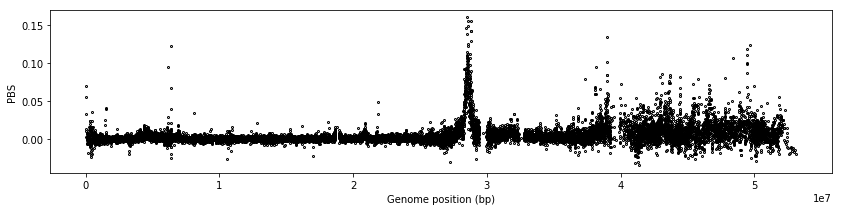

In [23]:
fig, ax = plt.subplots(figsize=(14, 3))
x = (starts + ends) / 2
ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
ax.set_xlabel('Genome position (bp)')
ax.set_ylabel('PBS');

In [24]:
# watch the dask dashboard
starts, ends, y = pbs('3R', 'BFcol', 'UGgam', 'GW')

distributed.utils - ERROR - Worker already exists tcp://10.8.64.5:37483
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/utils.py", line 648, in log_errors
    yield
  File "/opt/conda/lib/python3.6/site-packages/distributed/scheduler.py", line 1283, in add_worker
    raise ValueError("Worker already exists %s" % address)
ValueError: Worker already exists tcp://10.8.64.5:37483
distributed.core - ERROR - Worker already exists tcp://10.8.64.5:37483
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/core.py", line 346, in handle_comm
    result = yield result
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
  File "/opt/conda/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.6/site-packages/distributed/scheduler.py", line 1283, in add_worker
    raise ValueError("Worker

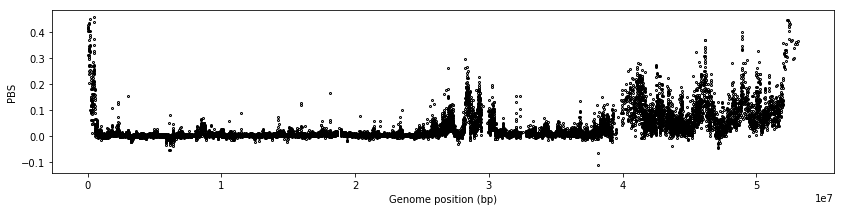

In [25]:
fig, ax = plt.subplots(figsize=(14, 3))
x = (starts + ends) / 2
ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
ax.set_xlabel('Genome position (bp)')
ax.set_ylabel('PBS');